In [1]:
import IJulia
import Base64

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = "QzpcVXNlcnNcc2doeXNcTXkgRHJpdmUgKHNnaHlzZWxpQHN0dWRlbnQudWJjLmNhKVxxdWFydG9cZ2l0aHViaW9cYmxvZ1xwb3N0c1xzY29yZW1hdGNoaW5n"
  if !isempty(run_path)
    run_path = String(Base64.base64decode(run_path))
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


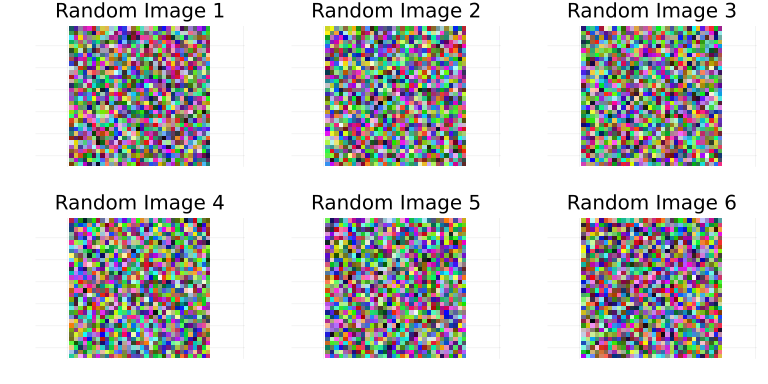

In [2]:
using Plots, Images

# Generate 6 random images and display them in a grid
plots = []
for i in 1:6
    # Generate a random 32x32 3-channel image
    im = rand(3, 32, 32)
    im = colorview(RGB, im)
    p = plot(im, showaxis=false, showgrid=false, title="Random Image $i")
    push!(plots, p)
end

# Create a plot with a 2x3 grid layout
plot_grid = plot(plots..., layout=(2, 3), size=(800, 400))

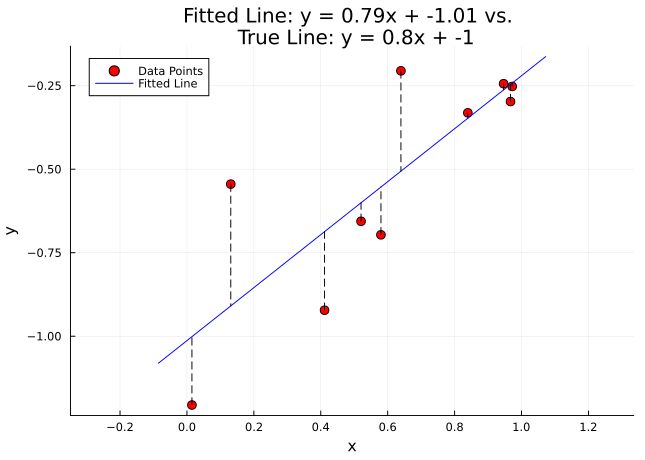

In [3]:
using Plots, Random

# Generate some random data points with correlation along a line
Random.seed!(1234)
n_points = 10
x = rand(n_points)
m_true = 0.8; b_true = -1
y = .8* x .- 1 + 0.3 * randn(n_points)

# Create the matrix X
X = hcat(ones(n_points), x)

# Solve the normal equations to find the parameters theta
theta = X \ y

# Generate x values for the complete line
x_line = range(minimum(x) - 0.1, maximum(x) + 0.1, length=100)
X_line = hcat(ones(length(x_line)), x_line)

# Compute the y values for the line
y_hat_line = X_line * theta

# Compute the fitted values for the original data points
y_hat = X * theta

# Unpack learned parameters
b, m = theta

# Plot the data points and the fitted line
title_text = "Fitted Line: y = $(round(m, digits=2))x + $(round(b, digits=2)) vs. \n True Line: y = $(m_true)x + $(b_true)"
p1 = scatter(x, y, label="Data Points", color=:red, ms=5, aspect_ratio=:equal, xlabel="x", ylabel="y", title=title_text)
plot!(p1, x_line, y_hat_line, label="Fitted Line", color=:blue)
# Add dashed lines for residuals
for i in 1:n_points
    plot!(p1, [x[i], x[i]], [y[i], y_hat[i]], color=:black, linestyle=:dash, label="")
end

display(p1)

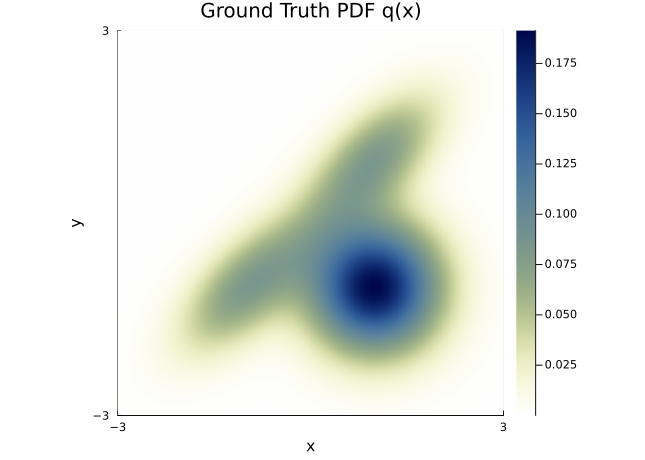

In [4]:
using Plots, Distributions

# Define the ground truth distribution
function p(x, y)
    mu1, mu2, mu3 = [-1, -1], [1, 1], [1, -1]
    sigma1, sigma2, sigma3 = [0.5 0.3; 0.3 0.5], [0.5 0.3; 0.3 0.5], [0.5 0; 0 0.5]

    return 0.2 * pdf(MvNormal(mu1, sigma1), [x, y]) + 0.2 * pdf(MvNormal(mu2, sigma2), [x, y]) + 0.6 * pdf(MvNormal(mu3, sigma3), [x, y])
end

# Plot the distribution using a heatmap
heatmap(
    -3:0.01:3, -3:0.01:3, p,
    c=cgrad(:davos, rev=true),
    aspect_ratio=:equal,
    xlabel="x", ylabel="y", title="Ground Truth PDF q(x)",
    xlims=(-3, 3), ylims=(-3, 3),
    xticks=[-3, 3], yticks=[-3, 3]
)

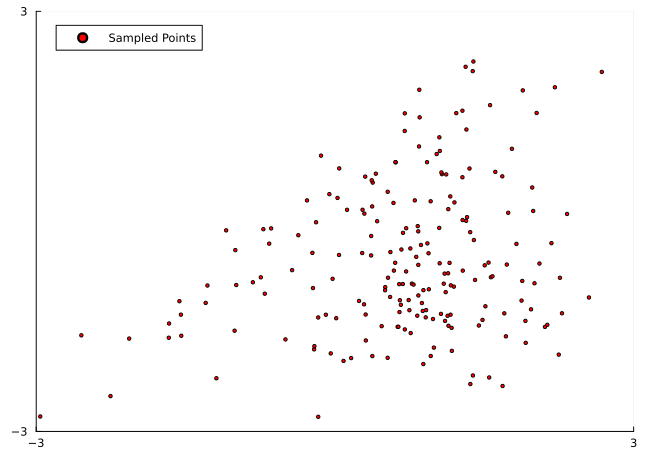

In [5]:
using Random, Plots, Distributions

# Define the ground truth distribution
function p(x, y)
    mu1, mu2, mu3 = [-1, -1], [1, 1], [1, -1]
    sigma1, sigma2, sigma3 = [0.5 0.3; 0.3 0.5], [0.5 0.3; 0.3 0.5], [0.5 0; 0 0.5]

    return 0.2 * pdf(MvNormal(mu1, sigma1), [x, y]) + 0.2 * pdf(MvNormal(mu2, sigma2), [x, y]) + 0.6 * pdf(MvNormal(mu3, sigma3), [x, y])
end

# Sample 200 points from the ground truth distribution
n_points = 200
points = []

# Set random seed for reproducibility
Random.seed!(1234)

while length(points) < n_points
    x = rand() * 6 - 3
    y = rand() * 6 - 3
    if rand() < p(x, y)
        push!(points, (x, y))
    end
end

# Plot the distribution using a heatmap
# heatmap(
#     -3:0.01:3, -3:0.01:3, p,
#     c=cgrad(:davos, rev=true),
#     aspect_ratio=:equal,
#     xlabel="x", ylabel="y", title="Ground Truth PDF q(θ)",

# )

# Scatter plot of the sampled points
scatter([x for (x, y) in points], [y for (x, y) in points], label="Sampled Points", color=:red, ms=2,
     xlims=(-3, 3), ylims=(-3, 3),
     xticks=[-3, 3], yticks=[-3, 3])

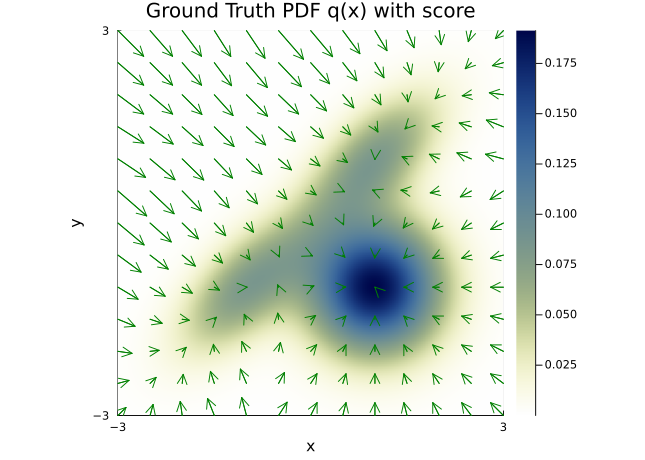

In [6]:
using Plots, Distributions, ForwardDiff

# Define the ground truth distribution
function p(x, y)
    mu1, mu2, mu3 = [-1, -1], [1, 1], [1, -1]
    sigma1, sigma2, sigma3 = [0.5 0.3; 0.3 0.5], [0.5 0.3; 0.3 0.5], [0.5 0; 0 0.5]

    return 0.2 * pdf(MvNormal(mu1, sigma1), [x, y]) + 0.2 * pdf(MvNormal(mu2, sigma2), [x, y]) + 0.6 * pdf(MvNormal(mu3, sigma3), [x, y])
end

# Define the log of the distribution
function log_p(x, y)
    val = p(x, y)
    return val > 0 ? log(val) : -Inf
end

# Function to compute the gradient using ForwardDiff
function gradient_log_p(u, v)
    grad = ForwardDiff.gradient(x -> log_p(x[1], x[2]), [u, v])
    return grad[1], grad[2]
end

# Generate a grid of points
xs = -3:0.5:3
ys = -3:0.5:3

# Create meshgrid manually
xxs = [x for x in xs, y in ys]
yys = [y for x in xs, y in ys]

# Compute the gradients at each point
U = []
V = []
for x in xs
    for y in ys
        u, v = gradient_log_p(x, y)

        push!(U, u)
        push!(V, v)
    end
end

# Convert U and V to arrays
U = reshape(U, length(xs), length(ys))
V = reshape(V, length(xs), length(ys))

# Plot the distribution using a heatmap
heatmap(
    -3:0.01:3, -3:0.01:3, p,
    c=cgrad(:davos, rev=true),
    aspect_ratio=:equal,
    xlabel="x", ylabel="y", title="Ground Truth PDF q(x) with score",
    xlims=(-3, 3), ylims=(-3, 3),
    xticks=[-3, 3], yticks=[-3, 3]
)

# Flatten the gradients and positions for quiver plot
xxs_flat = [x for x in xs for y in ys]
yys_flat = [y for x in xs for y in ys]

# Plot the vector field
quiver!(xxs_flat, yys_flat, quiver=(vec(U)/20, vec(V)/20), color=:green, quiverkeyscale=0.5)

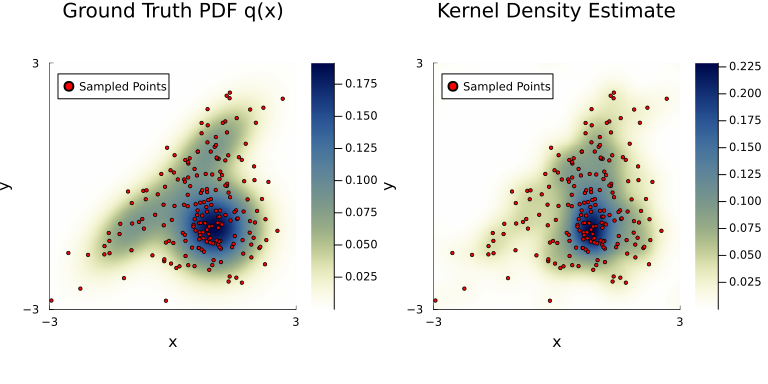

In [7]:
using Plots, Distributions, KernelDensity

# Convert points to x and y vectors
x_points = [x for (x, y) in points]
y_points = [y for (x, y) in points]

# Perform kernel density estimation using KernelDensity.jl
parzen = kde((y_points, x_points); boundary=((-3,3),(-3,3)), bandwidth = (.3,.3))

# Plot the ground truth PDF
p1 = heatmap(
    -3:0.01:3, -3:0.01:3, p,
    c=cgrad(:davos, rev=true),
    aspect_ratio=:equal,
    xlabel="x", ylabel="y", title="Ground Truth PDF q(x)",
    xlims=(-3, 3), ylims=(-3, 3),
    xticks=[-3, 3], yticks=[-3, 3]
)

# Scatter plot of the sampled points on top of the ground truth PDF
scatter!(p1, x_points, y_points, label="Sampled Points", color=:red, ms=2)


# Plot the kernel density estimate
p2 = heatmap(
    parzen.x, parzen.y, parzen.density,
    c=cgrad(:davos, rev=true),
    aspect_ratio=:equal,
    xlabel="x", ylabel="y", title="Kernel Density Estimate",
    xlims=(-3, 3), ylims=(-3, 3),
    xticks=[-3, 3], yticks=[-3, 3]
)

# Scatter plot of the sampled points on top of the kernel density estimate
scatter!(p2, x_points,  y_points, label="Sampled Points", color=:red, ms=2)

# Arrange the plots side by side
plot(p1, p2, layout = @layout([a b]), size=(800, 400))

Plots.AnimatedGif("C:\\Users\\sghys\\My Drive (sghyseli@student.ubc.ca)\\quarto\\githubio\\blog\\posts\\scorematching\\parzen_density_animation_with_gradients.gif")
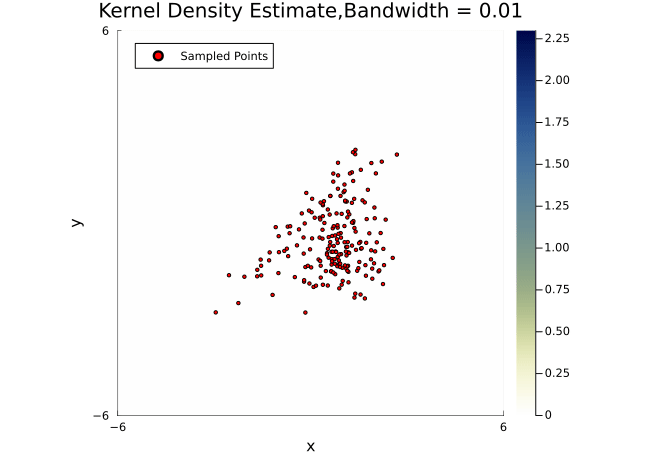

In [8]:
using Plots, Distributions, KernelDensity
# Define the range of bandwidths for the animation
bandwidths = [(0.01 + 0.05 * i, 0.01 + 0.05 * i) for i in 0:40]

# Create the animation
anim = @animate for bw in bandwidths
    kde_result = kde((x_points,y_points); boundary=((-6, 6), (-6, 6)), bandwidth=bw)

    p2 = heatmap(
        kde_result.x, kde_result.y, kde_result.density',
        c=cgrad(:davos, rev=true),
        aspect_ratio=:equal,
        xlabel="x", ylabel="y", title="Kernel Density Estimate,Bandwidth = $(round(bw[1],digits=2))",
        xlims=(-6, 6), ylims=(-6, 6),
        xticks=[-6, 6], yticks=[-6, 6]
    )

    scatter!(p2, x_points, y_points, label="Sampled Points", color=:red, ms=2)
end

# Save the animation as a GIF
gif(anim, "parzen_density_animation_with_gradients.gif", fps=2,show_msg = false)

Plots.AnimatedGif("C:\\Users\\sghys\\My Drive (sghyseli@student.ubc.ca)\\quarto\\githubio\\blog\\posts\\scorematching\\parzen_density_partials.gif")
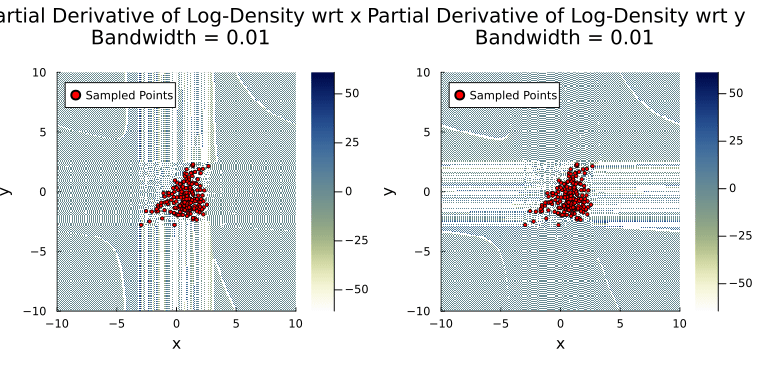

In [9]:
using Plots, Distributions, KernelDensity, ForwardDiff

# Define the range of bandwidths for the animation
bandwidths = [(0.01 + 0.05 * i, 0.01 + 0.05 * i) for i in 0:30]

boundary = (-10, 10)
# Create the animation
anim = @animate for bw in bandwidths
    kde_result = kde((x_points, y_points); boundary=(boundary, boundary), bandwidth=bw)

        # Compute log-density
    log_density = log.(kde_result.density)

    # Compute gradients of log-density
    grad_x = zeros(size(log_density))
    grad_y = zeros(size(log_density))

    # Compute gradients using finite difference centered difference
    for i in 2:size(log_density, 1)-1
        for j in 2:size(log_density, 2)-1
            grad_x[i, j] = (log_density[i+1, j] - log_density[i-1, j]) / (kde_result.x[i+1] - kde_result.x[i-1])
            grad_y[i, j] = (log_density[i, j+1] - log_density[i, j-1]) / (kde_result.y[j+1] - kde_result.y[j-1])
        end
    end
    # Downsample the gradients and coordinates by selecting every 10th point
    downsample_indices_x = 1:10:size(grad_x, 1)
    downsample_indices_y = 1:10:size(grad_y, 2)

    grad_x_downsampled = grad_x[downsample_indices_x, downsample_indices_y]
    grad_y_downsampled = grad_y[downsample_indices_x, downsample_indices_y]

    x_downsampled = kde_result.x[downsample_indices_x]
    y_downsampled = kde_result.y[downsample_indices_y]

    xxs_flat = repeat(x_downsampled, inner=[length(y_downsampled)])
    yys_flat = repeat(y_downsampled, outer=[length(x_downsampled)])

    grad_x_flat = grad_x_downsampled[:]
    grad_y_flat = grad_y_downsampled[:]

    # Plot heatmaps of the gradients
    p1 = heatmap(
        kde_result.x, kde_result.y, grad_x',
        c=cgrad(:davos, rev=true),
        aspect_ratio=:equal,
        xlabel="x", ylabel="y", title="Partial Derivative of Log-Density wrt x \n Bandwidth = $(round(bw[1],digits=2))",
        xlims=boundary, ylims=boundary
    )

    # Overlay the scatter plot of the sampled points
    scatter!(p1, x_points, y_points, label="Sampled Points", color=:red, ms=2)

    p2 = heatmap(
        kde_result.x, kde_result.y, grad_y',
        c=cgrad(:davos, rev=true),
        aspect_ratio=:equal,
        xlabel="x", ylabel="y", title="Partial Derivative of Log-Density wrt y \n Bandwidth = $(round(bw[1],digits=2))",
        xlims=boundary, ylims=boundary
    )

    # Overlay the scatter plot of the sampled points
    scatter!(p2, x_points, y_points, label="Sampled Points", color=:red, ms=2)

    plot(p1, p2, layout = @layout([a b]), size=(800, 400))
end
# Save the animation as a GIF
gif(anim, "parzen_density_partials.gif", fps=2, show_msg=false)

Plots.AnimatedGif("C:\\Users\\sghys\\My Drive (sghyseli@student.ubc.ca)\\quarto\\githubio\\blog\\posts\\scorematching\\parzen_density_gradient_animation_with_gradients.gif")
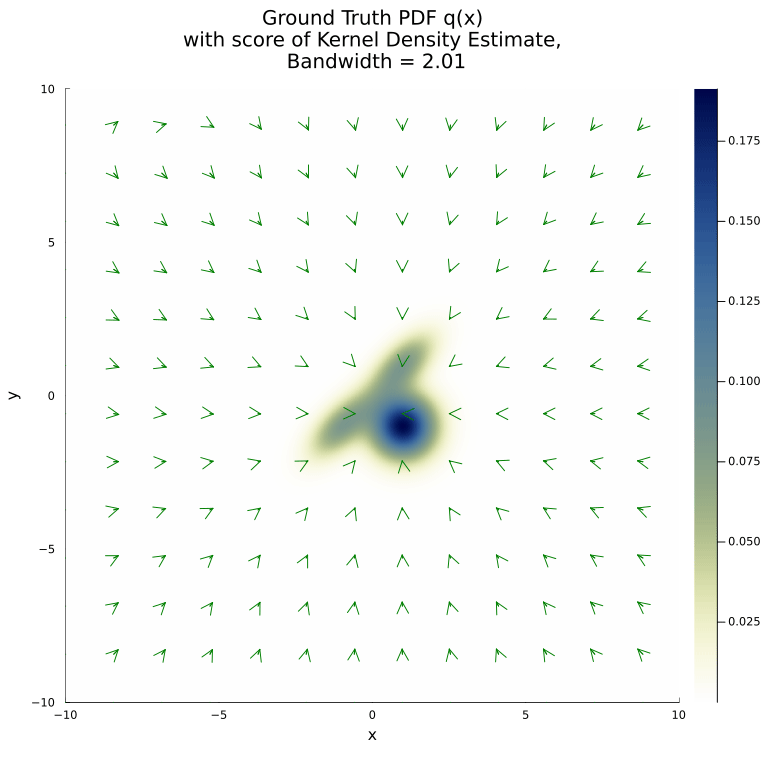

In [10]:
# Define the range of bandwidths for the animation
bandwidths = [(0.01 + 0.2 * i, 0.01 + 0.2 * i) for i in 0:10]
bandwidths = reverse(bandwidths)

boundary = (-10, 10)
# Create the animation
anim = @animate for bw in bandwidths
    kde_result = kde((x_points, y_points); boundary=(boundary, boundary), bandwidth=bw)

    # Compute log-density
    log_density = log.(kde_result.density)

    # Compute gradients of log-density
    grad_x = zeros(size(log_density))
    grad_y = zeros(size(log_density))

    # Compute gradients using finite difference centered difference
    for i in 2:size(log_density, 1)-1
        for j in 2:size(log_density, 2)-1
            grad_x[i, j] = (log_density[i+1, j] - log_density[i-1, j]) / (kde_result.x[i+1] - kde_result.x[i-1])
            grad_y[i, j] = (log_density[i, j+1] - log_density[i, j-1]) / (kde_result.y[j+1] - kde_result.y[j-1])
        end
    end
    # Downsample the gradients and coordinates by selecting every 10th point
    downsample_indices_x = 1:20:size(grad_x, 1)
    downsample_indices_y = 1:20:size(grad_y, 2)

    grad_x_downsampled = grad_x[downsample_indices_x, downsample_indices_y]
    grad_y_downsampled = grad_y[downsample_indices_x, downsample_indices_y]

    x_downsampled = kde_result.x[downsample_indices_x]
    y_downsampled = kde_result.y[downsample_indices_y]

    xxs_flat = repeat(x_downsampled, inner=[length(y_downsampled)])
    yys_flat = repeat(y_downsampled, outer=[length(x_downsampled)])

    grad_x_flat = grad_x_downsampled[:]
    grad_y_flat = grad_y_downsampled[:]

     # Plot the actual distribution
    x_range = boundary[1]:0.01:boundary[2]
    y_range = boundary[1]:0.01:boundary[2]
    p1 = heatmap(
        x_range, y_range, p,
        c=cgrad(:davos, rev=true),
        aspect_ratio=:equal,
        xlabel="x", ylabel="y", title="Ground Truth PDF q(x)\n with score of Kernel Density Estimate, \n Bandwidth = $(round(bw[1],digits=2))",
        xlims=boundary, ylims=boundary,
        size=(800, 800)
    )

    # Plot a quiver plot of the downsampled gradients
    quiver!(yys_flat, xxs_flat, quiver=(grad_x_flat/10, grad_y_flat/10), 
    color=:green, quiverkeyscale=0.5, aspect_ratio=:equal)
end
# Save the animation as a GIF
gif(anim, "parzen_density_gradient_animation_with_gradients.gif", fps=2, show_msg=false)